In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pyarrow
import plotly.graph_objects as go
import plotly.express as px

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# functions
def rename_columns(df):
    """
    input: the dataset we want to rename the columns
    output: combine the first row of the dataset into the original column
    """
    original_columns = df.columns
    num_col = df.shape[1]
    first_row = df.iloc[0] #grab the first row for the header
    df = df[1:] #take the data below the first row
    # create a list containing new column names
    new_cols = []
    for col in range(num_col):
        new_col_name = original_columns[col] + '_' + first_row[col]
        new_cols.append(new_col_name)
    df.columns = new_cols # assign the new column names to the dataset
    return df

def replace_nan(df):
    """
    input:
    df - the target dataset
    
    output:
    a new dataset with nan values replaced as 0 and non-nan values replaced with 1
    """
    array = np.where(df.isnull(),0,1)
    df = pd.DataFrame(data=array, columns=df.columns)
    df.index = df.index + 1
    return df

def split_cols(df):
    """
    input:
    df - target dataframe
    
    output:
    single_questions - a list of column names that belong to single question column
    multiple_questions - a list of column names that belong to multiple question column
    """
    single_questions = []
    multiple_questions = []
    for col in df.columns:
        if 'part' in col.lower() or 'other' in col.lower():
            multiple_questions.append(col)
        else:
            single_questions.append(col)
    return single_questions, multiple_questions

def pivot_col(df, col):
    """
    input:
    df - target dataset
    col - the column we want to pivot its value as new columns
    
    output:
    return a pivoted dataframe where columns are value from the col of old dataframe
    """
    df['participant_id'] = df.index
    pivoted_df = df.pivot(index = 'participant_id', columns=col, values=col).reset_index().iloc[: , 1:]
    pivoted_df.index = pivoted_df.index + 1
    return pivoted_df

def pivot_df(df):
    """
    input:
    df - targer dataframe
    var_cols - a list of column names we want to pivot
    aggr - the column we used to group by the dataset
        
    output:
    return a dataframe where each column comes from value of each col of old dataframe
    NaN value replaced with 0 while non-NaN value replaced with 1
    """
    
    pivoted_df = []
    for col in df.columns:
        if col in single_questions: ## single question answers
            pivoted = pivot_col(df[[col]], col)
            pivoted_df.append(pivoted)
        else:
            pivoted_df.append(df[[col]])
    pivoted_merged_df = pd.concat(pivoted_df, axis=1, ignore_index=False)
    return pivoted_merged_df

def closest_participant(participant_id, participant_matrix):
    """
    input:
    participant_id - target participant
    participant_matrix - matrix where shows the similarity between each participant
    
    output - the list of participants other than the target participant, ranked by similarity
    """
    participant_list = participant_matrix[[participant_id]]
    participant_list = participant_list.sort_values(by = participant_id, ascending = False)
    
    return participant_list.index[1:]

def compensation(df , participant):
    """
    input -
    df - target dataset
    participant - the id of the participant
    
    output -
    the yearly compensation of that participant
    """
    
    compensation = df.loc[df.index == participant]['Q25_What is your current yearly compensation (approximate $USD)?'].iloc[0]
    
    return compensation

def similar_user_compensation(df, participant_ids):
    """
    input:
    df - target dataset
    participant_ids - a list of participant ids
    output:
    the first participant id that has non-null compensation data
    """
    for participant in participant_ids:
        if compensation(df, participant) is not None:
            return compensation(df, participant)
        else:
            pass

def same_answers(df, user_1, user_2):
    """
    input
    df - target dataset
    user_1 - index number of user 1
    user_2 - index number of user 2
    
    output
    same_cols - return the column names where answer are same between user 1 and 2
    different_cols - return the column names where answer are different between user 1 and 2
    """
    same_cols = []
    different_cols = []
    answers = df.loc[df.index.isin([user_1,user_2])]
    for col in answers.columns:
        if answers[col].iloc[0] == answers[col].iloc[1]:
            same_cols.append(col)
        else:
            different_cols.append(col)
    return same_cols, different_cols

def compute_correlation(df, user1, user2):
    '''
    INPUT
    user1 - int user_id
    user2 - int user_id
    df - dataset where is a matrix of user and their pivoted answer columns
    OUTPUT
    the correlation between the matching ratings between the two users
    '''
    answer_1 = list(df.loc[df.index == user1].iloc[0])
    answer_2 = list(df.loc[df.index == user2].iloc[0])
    
    dot_product = np.vdot(answer_1, answer_2)
    
    return dot_product #return the correlation

def subset_data(df, col, criteria):
    """
    input:
    df: the dataset we want to subset from
    col: target columns as the filter
    criteria: value to feed the filter
    
    output:
    a new dataset which is a subset of the original one
    """
    
    new_df = df.loc[df[col] == criteria]
    
    return new_df

def question_columns(df, query, method = 'strict'):
    """
    input: 
    df - target dataset
    query - str, query we want to find relevant infomation in the dataset. e.g. 'Q7', or 'machine learning' 
    
    output:
    a subset of data which include the columns of the query in interest
    
    method:
    if it == strict, which means we will look for the question exactly EQUALS to the query. e.g. if we search 'age', then 'language' won't
    be taken into account in this case;
    
    if it == loose, which means we will look for the question exactly CONTAINS the query. e.g. if we search 'age', then 'language' will
    be taken into account in this case.
    """
    columns = df.columns
    question_col = []
    for col in columns:
        if method == 'strict':
            col_parts = col.lower().split() # each column name will be separated into single word tokens at first
            if query.lower() in col_parts:
                question_col.append(col)
        elif method == 'loose':
            if query.lower() in col.lower():
                question_col.append(col)
    return df[question_col]

def kmeans_cluster_opt(df, init = 'k-means++', max_num_cluster = 9):
    """
    input: 
    df - the dataset we want to segments into cluster
    init - the way we want to initialize the starting centroid
    max_num_cluster - the max number of cluster
    
    output:
    a visualization showing the line graph indicating the optimal number of klusters, based on inertias value
    """
    num_clusters = list(range(1, max_num_cluster))
    inertias = []

    for k in num_clusters:
        model = KMeans(init=init, n_clusters=k, random_state = 42)
        model.fit(df)
        inertias.append(model.inertia_)

    
    plt.plot(num_clusters, inertias, '-o')

    plt.xlabel('number of clusters (k)')
    plt.ylabel('inertia')

    plt.show()

def kmeans_predict(df, init = 'k-means++', n_clusters = 4):
    """
    input:
    df - dataset we want to segment into clusters
    init - the way we want to initialize the starting centroid
    n_clusters - the number of cluster
    
    output:
    labels - return an array of predictions on the cluster label of given features
    centers - centroid values of each cluster
    """
    model = KMeans(init=init, n_clusters = n_clusters, random_state = 42)

    model.fit(df)

    labels = model.predict(df)
    
    centers = np.array(model.cluster_centers_)
    
    return labels, centers

def percentage_row(df):
    """
    input:
    df - target dataframe
    
    output - a new dataframe in which each cell represents the row 
    percengatge value of the corresponding one in the target dataframe
    
    """
    new_df = df.div(df.sum(axis=1), axis=0)
    new_df_share = round(new_df.apply(lambda x: x*100), 1).reset_index()
    return new_df_share

def cluster_aggr(df, cols):
    """
    input
    df: target dataset
    
    cols: columns of the question we are interested to see the segmentation
    
    output:
    a new dataframe that contains the number of participants for each question option
    """
    aggr = df.groupby(['cluster']).sum()
    aggr_col = aggr.iloc[:, cols]
    
    return aggr_col

def plot_bar_perc(df, cols):
    """
    input:
    df - target dataframe
    cols - columns we want to present as bars in the outcome chart
    
    output:
    a bar chart where each bar represents the share of each value in the column aggregated by cluster
    """
    fig = go.Figure()
    
    for col in cols:
        fig.add_trace(go.Bar(x=df['cluster'], 
                             y=df[col],
                            name = col))
    fig.show()
    
def cluster_question_plot(df, question):
    """
    input:
    df - target dataset
    
    question - the question we are interested to segmented by the cluster
    
    output:
    a list which contains a table and a plot showing the share of each segment per cluster
    """
    aggr_data = cluster_aggr(df, range(qs_num[question][0], qs_num[question][1]))
    aggr_perc = percentage_row(aggr_data)
    
    plot_chart = plot_bar_perc(aggr_perc, aggr_perc.columns[1:])
    
    return aggr_perc, plot_chart

# Cluster Analysis of Kaggle 2021 Survey Participants

## Introduction

## Problem Statement
The fundatmental question of this analysis is how many clusters regarding the statistical pattern users answer the survey differently. Based on that, I want to also understand -

1. How does the participant profile looks like per cluster?
I have grouped the survey questions into five - demograpgics, profession, knowledge and skillset, learning and development. It offers us various perspective to make the profile overall of each cluster.


2. Is there any similarity or relationship between the participant cluster? 

## Data Cleaning
The dataset is from [Kaggle Machine Learning & Data Science Survey](https://www.kaggle.com/competitions/kaggle-survey-2021). According to the competition host, it has collected 25,973 valid answers from Kaggle users. Kaggle is a free online data science community where participants could attend data science competitions. Its annual survey is representative to understand professionists in the data science world.

In [2]:
# load dataset
data = pd.read_parquet("/Users/jasmine/udacity_ds_nano_degree_capstone/data.parquet")

# first five rows
# data.head()

# remove the column Time from Start to Finish (seconds)
data = data.iloc[: , 1:]

# size of the dataset
data.shape # 25973 rows, 369 columns

print("The dataset has " + str(data.shape[0]) + " rows.")

print("The dataset has " + str(data.shape[1]) + " columns.")

The dataset has 25974 rows.
The dataset has 368 columns.


In [3]:
# make question as columne names
renamed_data = rename_columns(data)

# group questions into two categories
# single_questions if it is a single answer question
# multiple_questions if it is a multiple answer question
single_questions = split_cols(renamed_data)[0]
multiple_questions = split_cols(renamed_data)[1]

# pivot the dataset to one option one column
# turn answer as binary data where chosen is 1 and not chosen is 0 
pivoted_data = pivot_df(renamed_data)
binary_data = replace_nan(pivoted_data)

<ipython-input-1-0679920095c5>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['participant_id'] = df.index


## Method
This analysis adopts K-means to find participant clusters based on the pattern how they respond to the survey. It  aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster [link](https://en.wikipedia.org/wiki/K-means_clustering).

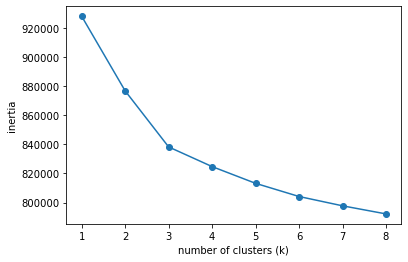

In [4]:
# explore how many number cluster can give a small enough inertia and also be as small number as possible
kmeans_cluster_opt(binary_data)

The chart shows the number 3 is an "elbow" at the line chart, which means segmenting the participants into three clusters could return us a good number of groups and a low error as well.

In [5]:
# create a new column cluster segmenting participants
# As the chart indicates above, we choose to make 3 clusters
binary_data['cluster'] = kmeans_predict(binary_data , n_clusters = 3)[0]

## Analysis

First of all, let's take a look at how many participants per each cluster.

In [6]:
binary_data.groupby(['cluster']).size()

cluster
0    11301
1     6945
2     7727
dtype: int64

In [7]:
# Question and its number of columns
qs_num = {
    "Age" : [0,11],
    "Gender" : [11,16],
    "Country" : [16,82],
    "HighEdu" : [82,89],
    "Employment" : [89,104],
    "CodeExp" : [104,111],
    "ProgLangReg" : [111,125],
    "ProgLangRec" : [125,138],
    "IDE" : [138,151],
    "HostNotebook" : [151, 169],
    "CompPlatMost" : [169,175],
    "HardwareReg" : [175,182],
    "TPUtimes" : [182, 187],
    "VisualLib" : [187,200],
    "MLmethd" : [200,209],
    "MLframe" : [209,227],
    "MLalgorithm" : [227,239],
    "CompVis" : [239,246],
    "NLP" : [246,253],
    "Industry" : [253,272],
    "SizeEmployer" : [272,278],
    "SizeDS" : [278,287],
    "DSBusiness" : [287,292],
    "WorkAct" : [292,301],
    "Compensation" : [301,328],
    "InvestDS" : [328, 334],
    "CldCompPltReg" : [334,347],
    "CldCompPltBstExp" : [347,360],
    "CldCompProdReg" : [360,365],
    "DataStoreProdReg" : [365,373],
    "ManageMLProdReg" : [373,383],
    "BigDataProdReg" : [383,405],
    "BigDataProdMost" : [405,425],
    "IntegenceReg" : [425,443],
    "IntegenceMost" : [443,459],
    "IsAutoML" : [459,467],
    "AutoMLReg" : [467,475],
    "MLexperiment" : [475,487],
    "PubShare" : [487,497],
    "Courses" : [497,510],
    "PrimaryTool" : [510,516],
    "FavMedia" : [516,528],
    "CldCompPltNxt" : [528,540],
    "CldCompProdNxt" : [540,545],
    "DataStoreProdNxt" : [545,553],
    "ManageMLProdNxt" : [553,563],
    "BigDataProdNxt" : [563,584],
    "IntegenceNxt" : [584,601],
    "AutoMLCatNxt" : [601,609],
    "AutoMLProdNxt" : [609,617],
    "MLexperimentNxt" : [617,629]
}

In [15]:
cluster_question_plot(binary_data, "Age")[0]

cluster  18-21  22-24  25-29  30-34  35-39  40-44  45-49  50-54  55-59  \
0        0   24.9   19.6   17.6   11.5    7.9    5.8    4.4    3.6    1.9   
1        1   25.4   22.0   19.1   10.9    8.3    5.5    3.7    2.4    1.5   
2        2    4.1   12.3   20.9   17.9   13.4   11.0    8.0    5.1    3.4   

   60-69  70+  
0    2.0  0.6  
1    0.9  0.3  
2    3.3  0.5

C0 and C1 both have highest shares in the age group between 18 to 21, taking 24.9% and 25.4% respectively.
As the age group increases, the share drops.

C2 The highest share age group is 25-29, followed by 30-34 and 35-39, which indicates the C2 participants are more likely older than C0 and C1 cluster participants.

In [16]:
cluster_question_plot(binary_data, "Gender")[0]

cluster   Man  Nonbinary  Prefer not to say  Prefer to self-describe  Woman
0        0  75.6        0.4                1.6                      0.2   22.2
1        1  78.4        0.3                0.9                      0.2   20.3
2        2  85.6        0.3                1.4                      0.1   12.5

All three clusters are male dominated. C2 has a relatively even higher share than C0 and C1 by over 7 percentage points. Correspondingly, the share of female participants of C2 is lower than 0 and 1.

In [33]:
developed_regions = ['cluster','Australia', 'Austria', 'Belgium',  'Canada',  
       'Denmark', 'France', 'Germany', 'Greece', 'Hong Kong (S.A.R.)',
       'Ireland', 'Israel', 'Italy', 'Japan', 'Netherlands', 'Norway', 'Portugal', 'Singapore',  'South Korea', 'Spain',
       'Sweden', 'Switzerland', 'Taiwan', 
       'United Kingdom of Great Britain and Northern Ireland',
       'United States of America']

BRICS = ['Brazil', 'China', 'India', 'Russia', 'South Africa'] 

In [38]:
cluster_question_plot(binary_data, "Country")[0][developed_regions]

cluster  Australia  Austria  Belgium  Canada  Denmark  France  Germany  \
0        0        1.0      0.2      0.2     1.2      0.2     1.4      1.6   
1        1        0.7      0.1      0.2     1.1      0.1     1.0      1.3   
2        2        1.4      0.3      0.3     1.6      0.3     2.2      2.5   

   Greece  Hong Kong (S.A.R.)  ...  Norway  Portugal  Singapore  South Korea  \
0     0.3                 0.3  ...     0.2       0.4        0.6          1.6   
1     0.4                 0.3  ...     0.1       0.5        0.9          0.9   
2     0.5                 0.4  ...     0.2       0.5        0.7          1.6   

   Spain  Sweden  Switzerland  Taiwan  \
0    1.5     0.2          0.2     1.3   
1    1.6     0.3          0.1     1.2   
2    2.3     0.5          0.4     1.4   

   United Kingdom of Great Britain and Northern Ireland  \
0                                                1.9      
1                                                1.7      
2                                                2.8      

   United States of America  
0                       9.5  
1                       7.5  
2                      13.7  

[3 rows x 25 columns]

C2 participants are more likely to reside in developed countries. C0 has slight more number of participants than C1 residing in developed regions.

In [39]:
cluster_question_plot(binary_data, "Country")[0][BRICS]

Brazil  China  India  Russia  South Africa
0     2.3    4.6   29.6     3.2           0.5
1     3.1    1.6   35.0     2.3           0.8
2     3.6    2.3   21.4     2.8           0.5

Expectedly, C2 don't have clearly more participants than any the other cluster in the BRICS countries, apart from Brazil. India is the biggest country that has the highest share of C1 cluster participants (35%), almost 5 times as the number as of the United States.

In [40]:
cluster_question_plot(binary_data, "HighEdu")[0]

cluster  Bachelor’s degree  Doctoral degree  I prefer not to answer  \
0        0               41.6              8.2                     3.5   
1        1               45.1              8.0                     1.8   
2        2               26.8             17.0                     1.4   

   Master’s degree  No formal education past high school  \
0             34.3                                   2.3   
1             36.1                                   1.3   
2             48.6                                   0.9   

   Professional doctorate  \
0                     1.2   
1                     1.0   
2                     2.0   

   Some college/university study without earning a bachelor’s degree  
0                                                8.9                  
1                                                6.7                  
2                                                3.4

C2 has the highest share of participants that will have Master’s degree, Professional doctorate	or Doctoral degree as the highest education level in the next 2 years.

In [41]:
cluster_question_plot(binary_data, "Employment")[0]

cluster  Business Analyst  Currently not employed  DBA/Database Engineer  \
0        0               4.1                     8.2                    0.7   
1        1               2.8                    15.0                    0.5   
2        2               4.0                     0.2                    0.8   

   Data Analyst  Data Engineer  Data Scientist  Developer Relations/Advocacy  \
0           8.8            2.1             7.5                           0.5   
1           6.2            1.3             7.5                           0.3   
2          11.3            4.5            29.1                           0.3   

   Machine Learning Engineer  Other  Product Manager  Program/Project Manager  \
0                        3.8   10.2              1.3                      3.1   
1                        3.3    7.7              0.6                      1.9   
2                       10.8    9.0              1.6                      4.7   

   Research Scientist  Software Engineer  Statistician  Student  
0                 4.8                9.2           1.5     34.1  
1                 3.5                6.5           0.7     42.2  
2                 9.7               12.4           1.3      0.3

Comparing C2 with C0 and C1 clusers, C2 has the highest, almost 4 times as any of the rest, share (~29.1%) of participants who are data scientists. On the other hand, C1 and 0 have highest shares of Unemployed and Students. 

In [42]:
cluster_question_plot(binary_data, "Industry")[0]

cluster  Academics/Education  Accounting/Finance  \
0        0                 22.7                 9.0   
1        1                 21.3                 8.1   
2        2                 16.8                 9.2   

   Broadcasting/Communications  Computers/Technology  Energy/Mining  \
0                          1.9                  20.9            3.5   
1                          1.9                  23.3            3.7   
2                          2.1                  28.7            3.3   

   Government/Public Service  Hospitality/Entertainment/Sports  \
0                        5.4                               1.0   
1                        5.0                               1.0   
2                        3.5                               1.1   

   Insurance/Risk Assessment  Manufacturing/Fabrication  Marketing/CRM  \
0                        2.2                        6.2            2.3   
1                        1.8                        5.3            2.0   
2                        3.2                        4.7            2.4   

   Medical/Pharmaceutical  Military/Security/Defense  Non-profit/Service  \
0                     4.3                        1.0                 2.3   
1                     4.3                        1.4                 2.2   
2                     5.3                        1.3                 1.4   

   Online Business/Internet-based Sales  \
0                                   1.5   
1                                   1.5   
2                                   1.9   

   Online Service/Internet-based Services  Other  Retail/Sales  \
0                                     2.7    7.8           3.6   
1                                     3.3    8.6           3.2   
2                                     4.4    5.7           3.1   

   Shipping/Transportation  NaN  
0                      1.8  0.0  
1                      2.1  0.0  
2                      2.0  0.0

Computer and Technology is the most popular industry for all of the clusters, C2 has the highest among the three, 5% and 8 percentage points higher than C1 and C0 respectively. On the other hand, the second most popular industry is Academia/Education. Even though cluster 2 has the highest share of master and doctor degree participants, its share that work in the Academia is comparatively lower. The third most popular industry is Finance/Accounting and the share of each cluster is actually close. 

In [43]:
cluster_question_plot(binary_data, "SizeEmployer")[0]

cluster  0-49 employees  10,000 or more employees  1000-9,999 employees  \
0        0            35.2                      18.9                  17.9   
1        1            33.1                      20.0                  17.5   
2        2            27.4                      23.0                  20.0   

   250-999 employees  50-249 employees  NaN  
0               12.7              15.3  0.0  
1               12.8              16.6  0.0  
2               13.8              15.8  0.0

Small size comannies take the highest share of every cluster, whereas C2 participants are more likely to work in big companies than C0 and C1.

In [44]:
cluster_question_plot(binary_data, "SizeDS")[0]

cluster     0   1-2  10-14  15-19   20+   3-4   5-9  NaN  I do not know
0        0  23.8  17.8    3.7    1.5  14.3  10.4   6.8  0.0           21.7
1        1  23.5  18.4    3.8    1.6  15.4  12.2   7.8  0.0           17.3
2        2   6.7  21.1    7.2    3.2  24.7  16.9  13.3  0.0            6.9

No surprise, C2 cluster has the higher share of data science colleagues at their employers than any other cluster. Over 40% of participants in either C0 or C1 have no idea how many people working in data scient or they claim none actually works at this field.

## Requiment
Python libraries are required to run this notebook

os/numpy/pandas/matplotlib/sklearn/pyarrow/plotly

## Acknowledge
The dataset for building this model is coming from Kaggle. Kudos to the Kaggle community!

## Conclusion

In [9]:
"""
By adopting K-means cluster analysis, I find there are three types of participants - C0, C1 and C2, depending on 

the answers they choose to the survey. I'd categorise questions into five groups

1. Demographics
    Q1_Age, Q2_Gender, Q3_Country, Q4_Highest_Education
    
2. Profession
    Q5_Role, Q19_industry, Q20_size_employer, Q21_size_ds, 
    Q22_ds_business, Q23_work_activity, Q24_compensation, Q25_invest
    
3. Tools
    Q9_IDE, Q10_hosted_notebook_product, Q11_computing_platform, Q12_specialized_hardware, Q13_TPU_times, 
    Q26_cloud_computing_platform_regular, Q27_cloud_computing_platform_exp, Q28_cloud_computing_product,
    Q29_data_storage_product, Q30_big_data_prod_regular, Q31_big_data_prod_most, Q32_intelligence_regular,
    Q33_intelligence_most, Q34_is_use_auto_ml, Q35_auto_ml_regular, Q36_ml_experiment, Q39_primary_tool
    
4. Knowledge and Skillset
    Q6_yr_coding, Q7_programming_language_regular, Q8_programming_language_recommend, Q14_visualization_lib,
    Q15_yr_machine_learning, Q16_machine_learning_framework, Q16_machine_learning_algorithm, Q17_computer_vision_method,
    Q18_nlp_method, Q37_pub_share, Q38_courses, Q40_fav_media, 
    
5. Development
    Q11_computing_platform_2yr, Q28_cloud_computing_product_2yr, Q29_data_storage_product_2yr, Q30_big_data_prod_2yr,
    _ml_prod_2yr, Q32_intelligence_2yr, Q35_auto_ml_2yr, Q36_ml_experiment_2yr
"""


"\nBy adopting K-means cluster analysis, I find there are three types of participants - C0, C1 and C2, depending on \n\nthe answers they choose to the survey. I'd categorise questions into five groups\n\n1. Demographics\n    Q1_Age, Q2_Gender, Q3_Country, Q4_Highest_Education\n    \n2. Profession\n    Q5_Role, Q19_industry, Q20_size_employer, Q21_size_ds, \n    Q22_ds_business, Q23_work_activity, Q24_compensation, Q25_invest\n    \n3. Tools\n    Q9_IDE, Q10_hosted_notebook_product, Q11_computing_platform, Q12_specialized_hardware, Q13_TPU_times, \n    Q26_cloud_computing_platform_regular, Q27_cloud_computing_platform_exp, Q28_cloud_computing_product,\n    Q29_data_storage_product, Q30_big_data_prod_regular, Q31_big_data_prod_most, Q32_intelligence_regular,\n    Q33_intelligence_most, Q34_is_use_auto_ml, Q35_auto_ml_regular, Q36_ml_experiment, Q39_primary_tool\n    \n4. Knowledge and Skillset\n    Q6_yr_coding, Q7_programming_language_regular, Q8_programming_language_recommend, Q14_visu

In [11]:
"""
col

0 : 11 - age
c0 and c1 younger groups 18-21, 22-24, 25-29

c2 30-34 highest share

c1 youngest

11 : 16 - gender
all male dominant
for cluster 2, the male is the highest over 85%


16 : 82 - country
Developing countries, China, India and Russia have lower shares in cluster 2,
while it is the opposite in western developed countries

82 : 89 - education
c2 has higher share of Doctoral degree than 1 and 2

89 : 104 - employment

c1 highest unemployed and students, c2 lowest

c0,1 students high

c2 ds 29%

c0,1 da, sfe

104 : 111 - coding exp
c2 highest

c0 least experienced in coding

111 : 125 - What programming languages do you use on a regular basis?
Python very close among the three clusters

c0,1 higher at C and C++

c2, higher at R and SQL

125 : 138 - recommend language for new ds

c0 has a same level with c2 that use Python as basis language in regular
however, c0 has 5% lower in recommeding DS to leanr Py than c2. 
R and SQL actually high in shares in C0, considering theri lower usage of both in regular basis

138 : 151 - Which of the following integrated development environments (IDE's) do you use on a regular basis? 

Jupyter notebook among three highest

Vim / Emacs c2 has double in shares, absolute value lowest though

c0 highest VS studio and Pycharm

151 : 169 Which of the following hosted notebook products do you use on a regular basis?

c0 33% no hostednoted book

169 : 175 Q11_What type of computing platform do you use most often for your data science projects?

c2 cloud computing and deep learning work station higher

c1 has highest share in laptop, 2% higher than c0


175 : 182 Q12_Part_1_Which types of specialized hardware do you use on a regular basis?

C2 have far more hardware than 1 and 0

182 : 187 Q13_Approximately how many times have you used a TPU (tensor processing unit)?

C2 used it more often than any of the other two

187 : 200 What data visualization libraries or tools do you use on a regular basis?

C2 has a wider range of visualization options e.g. shiny D3

200 : 209 - machine learning methods

Over 1 year is a critical period for ML learning

210 : 227 - Which of the following machine learning frameworks do you use on a regular basis?

C2 has a wider range of framework options

227 : 239 - Which of the following ML algorithms do you use on a regular basis?

C2 wider range

239 : 246 - Which categories of computer vision methods do you use on a regular basis?

c1 and c2 are very similar

246 : 253 - Which of the following natural language processing (NLP) methods do you use on a regular basis?

c2 has wider range

253 : 272 - industry
c0 and 1 higher in academics and education

c2 computer / tech / online business sales

272 : 278 - size of employer
c2 highest in largest employers

278 : 287 - Approximately how many individuals are responsible for data science workloads at your place of business?

c2 has the highest share in highest number

287 : 292 - Does your current employer incorporate machine learning methods into their business?

C2 highest in model in production

293 : 301 - Select any activities that make up an important part of your role at work

0 and 1 are more faciliate

2 is more advanced and automated?

301 : 328 - yearly compensation

c2 highest, then c0 , c1 lastly

328 : 334 - Approximately how much money have you (or your team) spent on machine learning and/or cloud computing services at home (or at work) in the past 5 years (approximate $USD)? 

c2 highest, then 0 and 1 almost none

334 : 347 - Which of the following cloud computing platforms do you use on a regular basis?

c2 has highest in almost all popular platforms

347 : 360 - Of the cloud platforms that you are familiar with, which has the best developer experience

C2 likes AWS while C1 likes Google Cloud platform

360 : 365 - Do you use any of the following cloud computing products on a regular basis?

c2 Amazon Elastic Compute Cloud  

c2 and c0 similar at Microsoft Azure Virtual Machines

365 : 373 - Do you use any of the following data storage products on a regular basis?

same trend as platform and product

373 : 383 - Do you use any of the following managed machine learning products on a regular basis?


383 : 405 - Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you use on a regular basis?
My SQL most popular among the three

405 : 425 - Which of the following big data products (relational database, data warehouse, data lake, or similar) do you use most often?

MySQL for all popular
Microsoft SQL server C1
PostgreSQL C2

425 : 443 - Which of the following business intelligence tools do you use on a regular basis?
C2 - C1 - C0
tableau
microsoft power bi

443 : 459 - Which of the following business intelligence tools do you use most often?
Microsoft Power BI
and Tableau

C2 has more flexiblity at the most often used bi tools

459 : 467 - Do you use any automated machine learning tools (or partial AutoML tools) on a regular basis?

c2 highest in each category

model selection, augmented data and parameter tuning

467 : 475 - Which of the following automated machine learning tools (or partial AutoML tools) do you use on a regular basis?
C2 has a lot more share choosing None

475 : 487 - Do you use any tools to help manage machine learning experiments?

Tensorflow, Weights and bias

487 : 497 - Where do you publicly share your data analysis or machine learning applications?
C2 wins at most categories

Github, Kaggle, Colab

497 : 510 - On which platforms have you begun or completed data science courses?

Platform certificats, udacity and coursera - c2

C2 don't really like Kaggle courses

510 : 516 - What is the primary tool that you use at work or school to analyze data?
C2 and 1 high in Local development environments (RStudio, JupyterLab, etc.
C0 basic statistic software

516 : 528 - Who/what are your favorite media sources that report on data science topics?

C2 podcast, journal, slack community and blogs

528 : 540 - Which of the following cloud computing platforms do you hope to become more familiar with in the next 2 years?
C2 highest in None!

540 : 545 - In the next 2 years, do you hope to become more familiar with any of these specific cloud computing products?
C2 highest in None!

545 : 553 - In the next 2 years, do you hope to become more familiar with any of these specific data storage products?
All NaN, data issue? No, they are all None actually.

553 : 563 - In the next 2 years, do you hope to become more familiar with any of these managed machine learning products?
C2 highest in None!

563 : 584 - Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you hope to become more familiar with in the next 2 years?
Amazon RDS, snowflake for C2
C2 highest in None!

584 : 601 - hich of the following business intelligence tools do you hope to become more familiar with in the next 2 years?
C2 highest in None!

601 : 609 - Which categories of automated machine learning tools (or partial AutoML tools) do you hope to become more familiar with in the next 2 years?
C2 Automated feature engineering/selection and parameter tuning

609 : 617 - Which specific automated machine learning tools (or partial AutoML tools) do you hope to become more familiar with in the next 2 years?
C2 highest in Other and None

617 : 629 - In the next 2 years, do you hope to become more familiar with any of these tools for managing ML experiments?
C2 TensorBoard and MLflow

high in None and Other
"""

"\n[['China','India','Germany',\n                      'United States of America',\n                      'United Kingdom of Great Britain and Northern Ireland',\n                     'Japan',\n                     'Australia',\n                     'Russia',\n                      'Sweden',\n                     'France',\n                     'South Korea',\n                     'Turkey']]\n"

In [12]:
# load dataset
# data = pd.read_csv("../input/kaggle-survey-2021/kaggle_survey_2021_responses.csv", low_memory = False)

#data_matrix = binary_data.dot(np.transpose(binary_data))